# Explore here

In [134]:
# Your code here
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

import warnings

In [135]:
data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")
data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633


In [136]:
data.info() #Dos columnas (variables) y 366 lineas (observaciones)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    366 non-null    object 
 1   sales   366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.8+ KB


In [137]:
data.isnull().sum() #El DataFrame no tiene datos nulos

date     0
sales    0
dtype: int64

In [138]:
#Ordenamos la columna de dates
data.sort_values(by="date", ascending=True)

,date,sales
0,2022-09-03 17:10:08.079328,55.292157
1,2022-09-04 17:10:08.079328,53.803211
2,2022-09-05 17:10:08.079328,58.141693
3,2022-09-06 17:10:08.079328,64.530899
4,2022-09-07 17:10:08.079328,66.013633
...,...,...
361,2023-08-30 17:10:08.079328,989.600354
362,2023-08-31 17:10:08.079328,994.987326
363,2023-09-01 17:10:08.079328,995.814415
364,2023-09-02 17:10:08.079328,997.350214


In [139]:
data["date"] = pd.to_datetime(data["date"])
data["date"] = data["date"].dt.strftime("%Y-%m-%d")
data.set_index("date", inplace=True)

In [140]:
data.head()

,sales
date,
2022-09-03,55.292157
2022-09-04,53.803211
2022-09-05,58.141693
2022-09-06,64.530899
2022-09-07,66.013633


In [141]:
ts = data["sales"]
ts.head()

date
2022-09-03    55.292157
2022-09-04    53.803211
2022-09-05    58.141693
2022-09-06    64.530899
2022-09-07    66.013633
Name: sales, dtype: float64

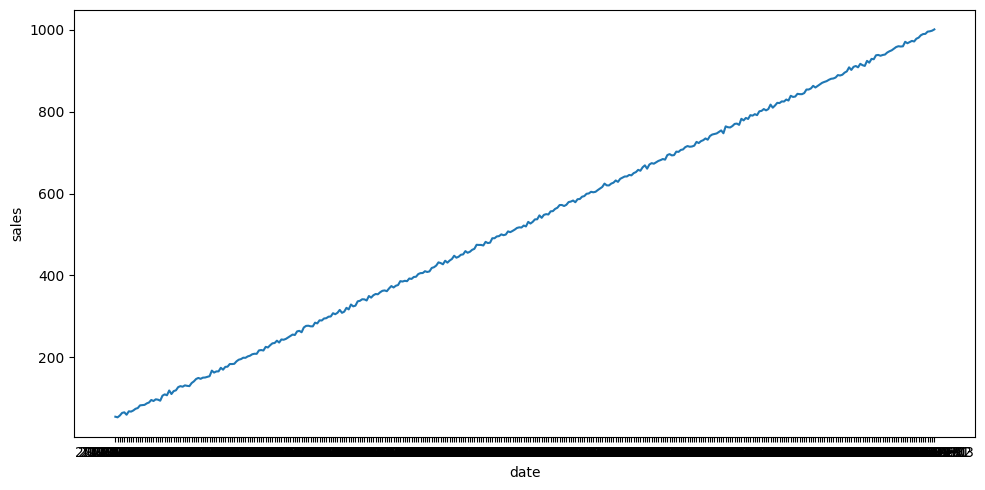

In [142]:
import matplotlib.dates as mdates
fig, axis = plt.subplots(figsize = (10,5))

sns.lineplot(ts)

plt.tight_layout()
plt.show()

Vemos que tiene una clara tendencia ascendente, la estacionalidad no está clara y la variabilidad en un principio es leve.

In [143]:
decomposition = seasonal_decompose(ts, period = 12)
decomposition

Análisis de tendencia

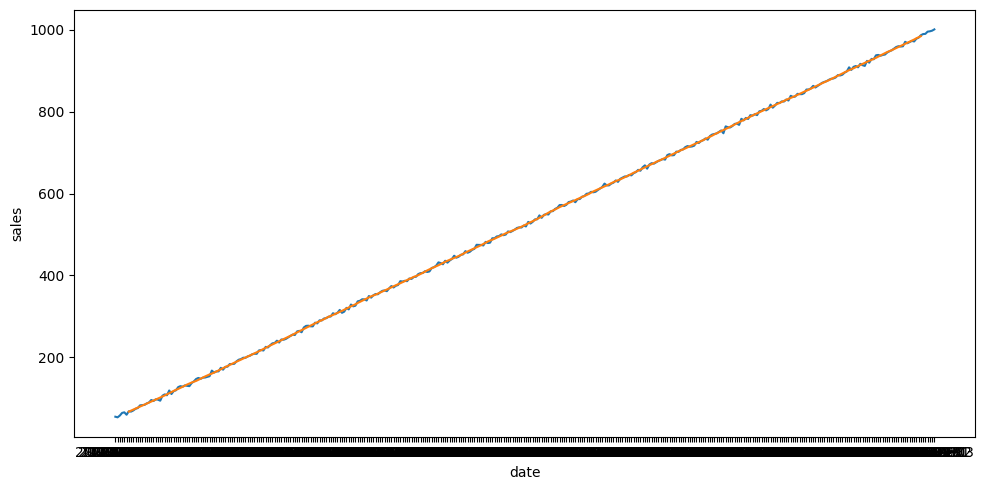

In [144]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize=(10,5))

sns.lineplot(data= ts)
sns.lineplot(data = trend)

plt.tight_layout()
plt.show()

Confirmamos que existe una clara tendencia positiva. El número de ventas tiende a aumentar positivamente cada año

Análisis de estacionalidad

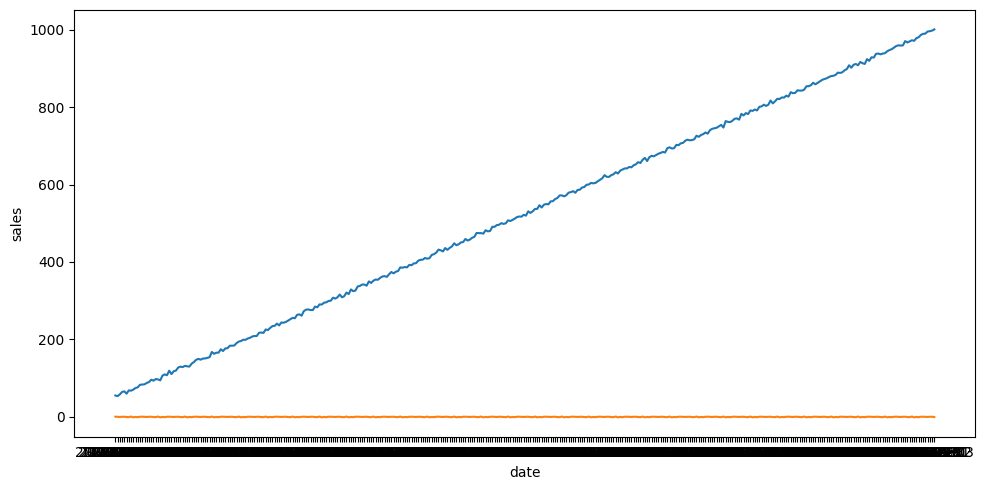

In [145]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize=(10,5))

sns.lineplot(data= ts)
sns.lineplot(data = seasonal)

plt.tight_layout()
plt.show()

Los datos muestran valores repetitivos a lo largo del año (existe una estacionalidad en cada año dependiendo del mes).
Vamos a realizar la prueba de Dickey-Fuller para evaluar la estacionalidad de los datos

In [146]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

In [147]:
test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.545414
p-value                          0.986190
#Lags Used                      13.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64

Ya que nuestro p-valor del test es superior a 0.05, rechazamos la hipótesis nula y por lo tanto nuestra serie de datos no es estacionaria. Los valores estadísticos no son constantes en la muestra, pero esto no quiere decir que la serie no es estacional.

Proceso de Diferenciación

In [148]:
sales_dif = ts.diff().dropna()
sales_dif

date
2022-09-04   -1.488946
2022-09-05    4.338482
2022-09-06    6.389205
2022-09-07    1.482734
2022-09-08   -5.931768
                ...   
2023-08-30    0.518681
2023-08-31    5.386972
2023-09-01    0.827090
2023-09-02    1.535798
2023-09-03    3.132571
Name: sales, Length: 365, dtype: float64

In [149]:
test_stationarity(sales_dif)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.430263e+00
p-value                        5.212954e-16
#Lags Used                     1.200000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64

Ahora si que vemos que el p-valor se ha reducido considerablemente despues de haber realizado la diferenciación de los datos con sus datos anteriores. Por lo que no rechazamos la hipótesis nula y podemos decir que nuestra serie si que es estacionaria

Análisis de variabilidad

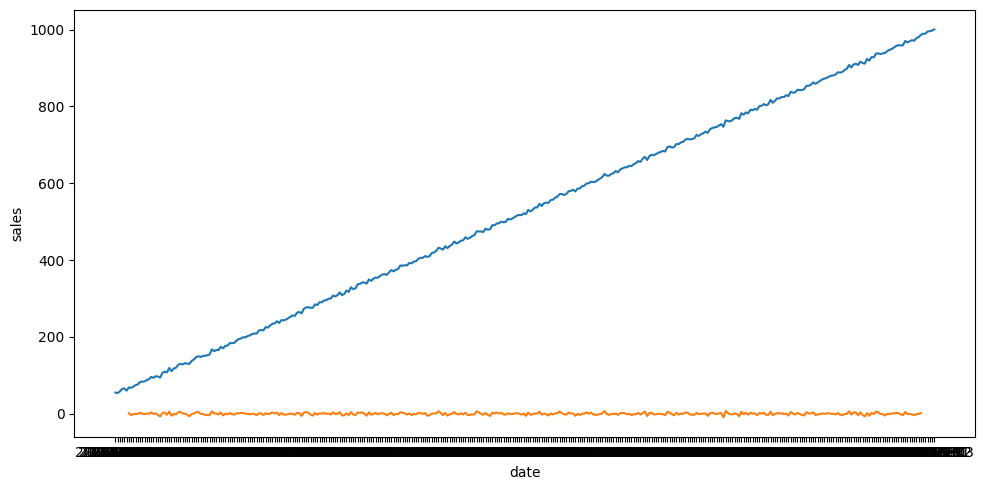

In [150]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize=(10,5))

sns.lineplot(data= ts)
sns.lineplot(data = residual)

plt.tight_layout()
plt.show()

Vemos que los residuos se encuentran alrededor de 0, lo que significa que la descomposición es adecuada.

Funciones de autocorrelación

Función de autocorrelación (ACF)

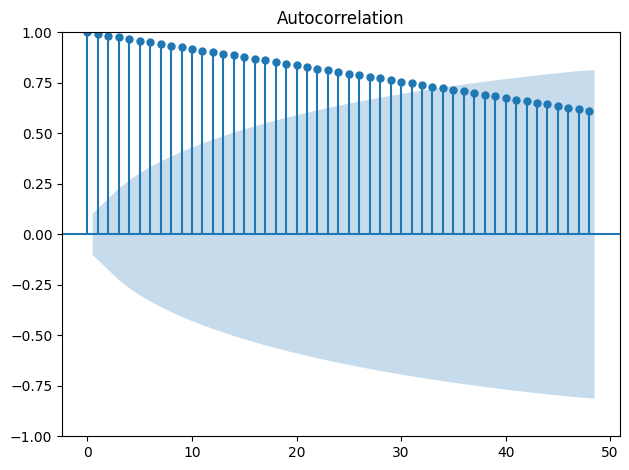

In [151]:
plot_acf(ts, lags=48)

plt.tight_layout()
plt.show()

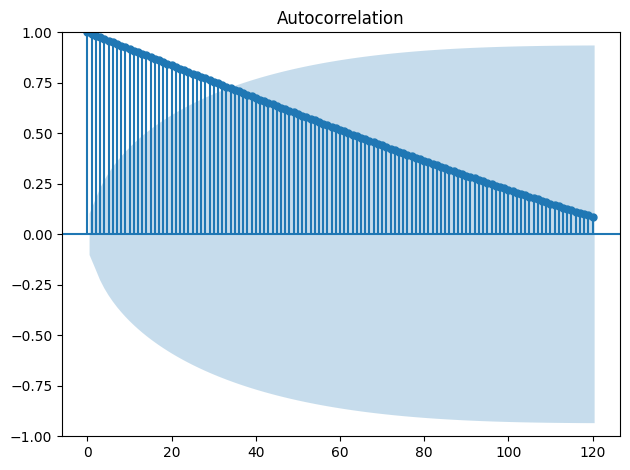

In [152]:
plot_acf(ts, lags=120)

plt.tight_layout()
plt.show()

Vemos que existe una alta correlación que va disminuyendo de forma uniforme a medida que va pasando el tiempo. Existe una correlación inversa, cuanto más pase el tiempo menos autocorrelación tienen los datos. Hasta el lag 30 (aproximadamente) las barras se encontraban por encima de las líneas de confianza, por lo que la correlación era significativa. A partir de ese lag, el resto están por debajo y por lo tanto dejan de ser significativas.

Función de Autocorrelación Parcial (PACF)

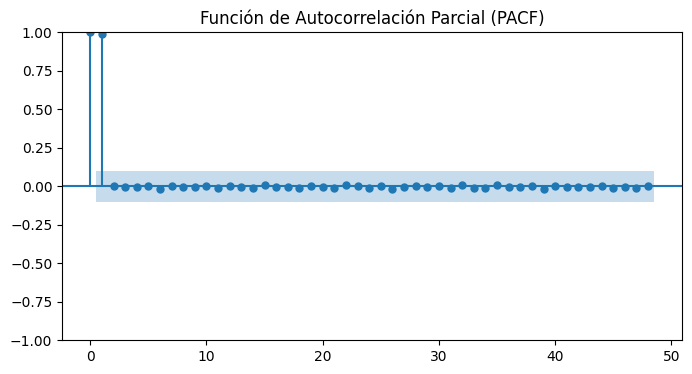

In [153]:
plt.figure(figsize=(8, 4))
plot_pacf(ts, lags=48, ax=plt.gca())
plt.title('Función de Autocorrelación Parcial (PACF)')
plt.show()

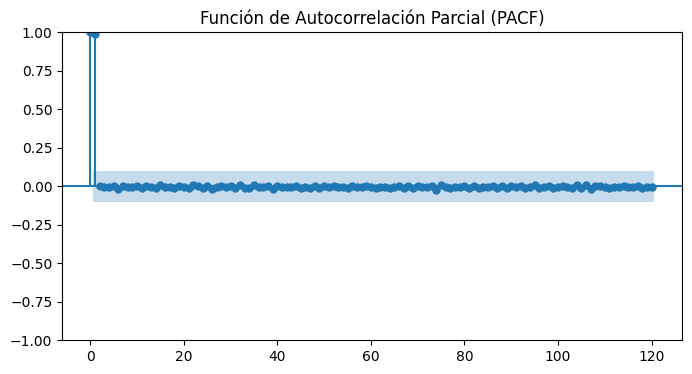

In [154]:
plt.figure(figsize=(8, 4))
plot_pacf(ts, lags=120, ax=plt.gca())
plt.title('Función de Autocorrelación Parcial (PACF)')
plt.show()

Prácticamente todos los coeficientes, menos los dos primeros, caen dentro de la zona marcada. Por lo que no se consideran significativos, podrían ser resultados del azar probablemente.

Entrenamiento automático del modelo

In [155]:
model = auto_arima(ts, seasonal = True, trace = True, m = 12)

/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1847.125, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1972.853, Time=0.14 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2209.657, Time=0.02 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1844.695, Time=0.82 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1843.274, Time=0.42 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=0.87 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=1843.586, Time=0.22 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=1841.532, Time=0.36 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=1843.437, Time=0.83 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=0.82 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.10 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=1839.552, Time=0.16 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=1841.456, Time=0.86 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1841.455, Time=0.35 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=1843.455, Time=0.70 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1839.586, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=1970.972, Time=0.04 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=1839.607, Time=0.19 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=1922.648, Time=0.06 sec


/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[12]             : AIC=inf, Time=0.15 sec

Best model:  ARIMA(1,1,1)(0,0,0)[12] intercept
Total fit time: 10.135 seconds


El modelo de ARIMA más eficiente, según el análisis que acabamos de realizar, es:
- p: 1
- d: 1
- q: 1

In [156]:
forecast = model.predict(12)
forecast

/home/vscode/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


2023-09-04    1002.158148
2023-09-05    1004.831668
2023-09-06    1007.423289
2023-09-07    1010.021630
2023-09-08    1012.619419
2023-09-09    1015.217253
2023-09-10    1017.815084
2023-09-11    1020.412915
2023-09-12    1023.010746
2023-09-13    1025.608577
2023-09-14    1028.206408
2023-09-15    1030.804239
Freq: D, dtype: float64

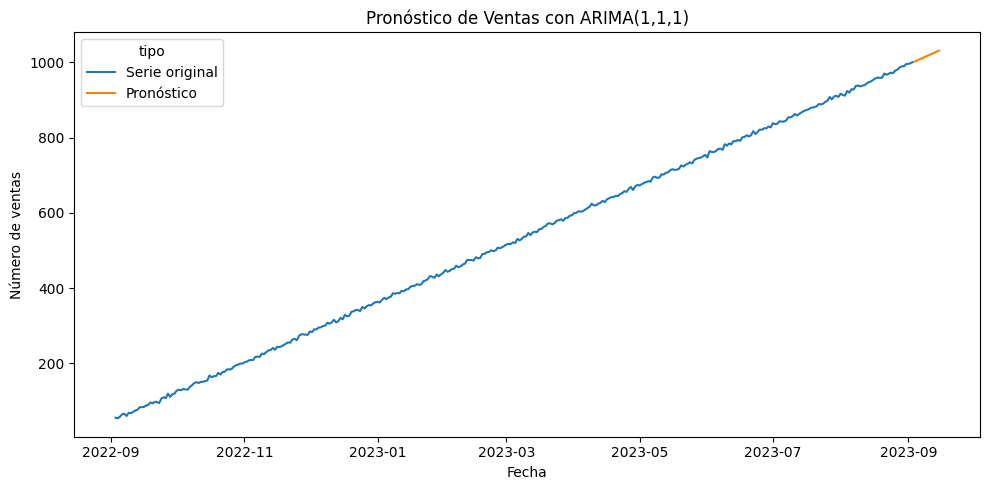

In [159]:
#Quito el valor del índice de las fechas porque no me dejaba graficar los datos
df_ts = ts.reset_index()
df_ts.columns = ['fecha', 'valor']
df_ts['fecha'] = pd.to_datetime(df_ts['fecha'])
df_ts['tipo'] = 'Serie original'

df_forecast = forecast.reset_index()
df_forecast.columns = ['fecha', 'valor']
df_forecast['fecha'] = pd.to_datetime(df_forecast['fecha'])
df_forecast['tipo'] = 'Pronóstico'

df = pd.concat([df_ts, df_forecast], ignore_index=True)


plt.figure(figsize=(10, 5))
sns.lineplot(data=df, x='fecha', y='valor', hue='tipo')

plt.title("Pronóstico de Ventas con ARIMA(1,1,1)")
plt.xlabel("Fecha")
plt.ylabel("Número de ventas")
plt.tight_layout()
plt.show()

Vemos como la predicción sigue la misma tendencia positiva, ya que todos los datos anteriores han seguido claramente una tendencia positiva